In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from torch_geometric.loader import DataLoader
from dataset_copy import *
from model import *
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = 'cpu'

Dataset type:  <class 'dataset_copy.ChiralLigands'>
Dataset node features:  7
Dataset length:  <bound method ChiralLigands.len of ChiralLigands(686)>
Dataset sample:  Data(x=[92, 7], edge_index=[2, 196], edge_attr=[196, 2], y=[1], category=[1], ligand='C1=C(Cc2ccccc2)[C@H]2C=C(Cc3ccccc3)[C@@H]1C2', substrate='O=C1C=CCC1', boron='c1ccc(B2OB(c3ccccc3)OB(c3ccccc3)O2)cc1', ligand_num=1, ligand_id='L3.1', ligand_fam='fam1', idx=0)
Sample features:  tensor([[6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 4., 4., 0., 1., 1., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 3., 3., 0., 1., 0., 1.],
        [6., 4., 4., 0., 0., 0., 1.],
        [6., 3., 3., 1., 1., 0., 1.],
        [6., 3., 3.,

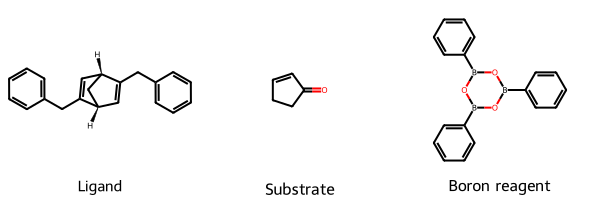

In [4]:
ligands = ChiralLigands(root = '/Users/ed/Documents/PhD_Documents/Experiments/ChiralLigands/Data_augm_exp/Data/Ligands_augmentation', filename = 'data_aug.csv')

print("Dataset type: ", type(ligands))
print("Dataset node features: ", ligands.num_features)
print("Dataset length: ", ligands.len)
print("Dataset sample: ", ligands[0])
print('Sample features: ',  ligands[0].x)
print('Sample outcome: ',  ligands[0].y)
print('Sample cat: ',  ligands[0].category)

ms = [ligands[0].ligand, ligands[0].substrate, ligands[0].boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [5]:
model = GCN_loop(ligands.num_features, embedding_size = 64, gnn_layers=2, improved=False)
#model = GAT_loop(data.num_features, embedding_size = 1, gnn_layers=1, nheads=1, concat=False)
model.to(device)

GCN_loop(
  (initial_conv): GCNConv(7, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

In [7]:
categories = np.array([ligands[i].category.detach().numpy() for i in range(len(ligands))])
x = [ligands[i].x.detach().numpy() for i in range(len(ligands))]
groups = [ligands[i].ligand_num for i in range(len(ligands))]

In [8]:
folds = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
train_idx = []
test_idx = []

for i, (train, test) in enumerate(folds.split(x, categories, groups)):
    train_idx.append(train)
    test_idx.append(test)

In [9]:
fold = 9
train_loader = DataLoader(ligands[train_idx[fold]], batch_size=40, shuffle=True)
test_loader = DataLoader(ligands[test_idx[fold]], batch_size=40, shuffle=False)

In [10]:
def calculate_metrics(y_pred, y_true, epoch, type):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    
    if epoch % 100 == 0:
        print('\n \n' + type)
        print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
        print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {rec:.2f}")
        print(f"ROC AUC: {roc:.2f}")

    return prec, rec, roc 

In [11]:
def train(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
      loss.backward()  
      # Update using the gradients
      optimizer.step()   

      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'train')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [12]:
def test(epoch):

    all_preds = []
    all_y = []
    total_loss = 0
    step = 0

    # Enumerate over the data
    for batch in test_loader:
      # Use GPU
      batch.to(device)  
      # Passing the node features and the connection info
      pred = model(batch.x.float(), 
                  batch.edge_index,
                  batch.batch) 
      
      # Calculating the loss and gradients
      loss = loss_fn(pred, torch.unsqueeze(batch.category.float(), dim = 1))
  
      total_loss += loss.item()
      step += 1

      all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
      all_y.append(batch.category.cpu().detach().numpy())

    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate (all_y).ravel() 
    metrics = calculate_metrics(all_preds, all_labels, epoch, 'test')

    return torch.tensor(total_loss/step), all_preds, all_labels, metrics

In [13]:
epochs = 231

loss_train = []
loss_test = []

pred_train = []
pred_test = []

labels_train = []
labels_test = []

prec_train = []
prec_test = []

rec_train = []
rec_test = []

roc_train = []
roc_test = []

best_loss = 10_000
early_stopping_counter =0

In [14]:
model_directory = '/Users/ed/Documents/PhD_Documents/Experiments/ChiralLigands/Data_augm_exp/GNN/saved_models/'
model_filename = f'GCN_f_{fold}_l_{model.gnn_layers}_em_{model.embedding_size}_e_{epochs}.pth'
model_filepath = os.path.join(model_directory, model_filename)

In [15]:
if os.path.exists(model_filepath):
    # Load the existing model
    model = torch.load(model_filepath)

else:
    for epoch in range (epochs):
                
        if early_stopping_counter <= 1000:
            # Training
            model.train()
            loss, pred, label, metrics = train(epoch=epoch)
            loss = loss.detach().cpu().numpy()

            if epoch % 5 == 0:
                loss_train.append(loss) 
                prec_train.append(metrics[0])
                rec_train.append(metrics[1])
                roc_train.append(metrics[2])

            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Train Loss {loss}")
                pred_train.append(pred)
                labels_train.append(label)

                    # Testing
                
            if epoch % 5 == 0:
                model.eval()
                loss, pred, label, metrics = test(epoch=epoch)
                loss = loss.detach().cpu().numpy()

                if float(loss) < best_loss:
                    best_loss = loss
                    early_stopping_counter = 0
                    best_pred = pred
                    best_y = label
                    best_prec = metrics[0]
                    best_rec = metrics[1]
                    best_roc = metrics[2]
                    best_epoch = epoch

                else:
                    early_stopping_counter += 1

                
                loss_test.append(loss)
                prec_test.append(metrics[0])
                rec_test.append(metrics[1])
                roc_test.append(metrics[2])

                if epoch % 10 == 0:
                    print(f"Epoch {epoch} | Test Loss {loss}")
                    pred_test.append(pred)
                    labels_test.append(label)
        
            last_epoch = epoch
                    
        else:
            print("Early stopping due to no improvement.")
            print(f'Best loss was {best_loss}')
            last_epoch = epoch
            #break

    print(f'Finishing training with best test loss: {best_loss}')
    print(f'Best test precision: {best_prec}')
    print(f'Best test recall: {best_rec}')
    print(f'Best test auroc: {best_roc}')
    print(f'Best epoch: {best_epoch}')
    torch.save(model, model_filepath)

In [16]:
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer
from plot_importances import *

In [17]:
feat_labels = ['Atomic number', 'Atom degree', 'Atom hybridization', 'Aromaticity', 'Atom in ring', 'Atom chirality', 'Molecule configuration']

In [18]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('ShapleyValueSampling'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    ),
)

In [19]:
explain = DataLoader(ligands[test_idx[fold]], batch_size=1)

In [20]:
mol = get_graph_by_idx(explain, 438)

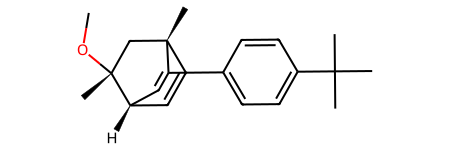

In [21]:
Chem.MolFromSmiles(mol.ligand[0])

In [22]:
explanation = explainer(x = mol.x, edge_index=mol.edge_index,  batch_index=mol.batch)

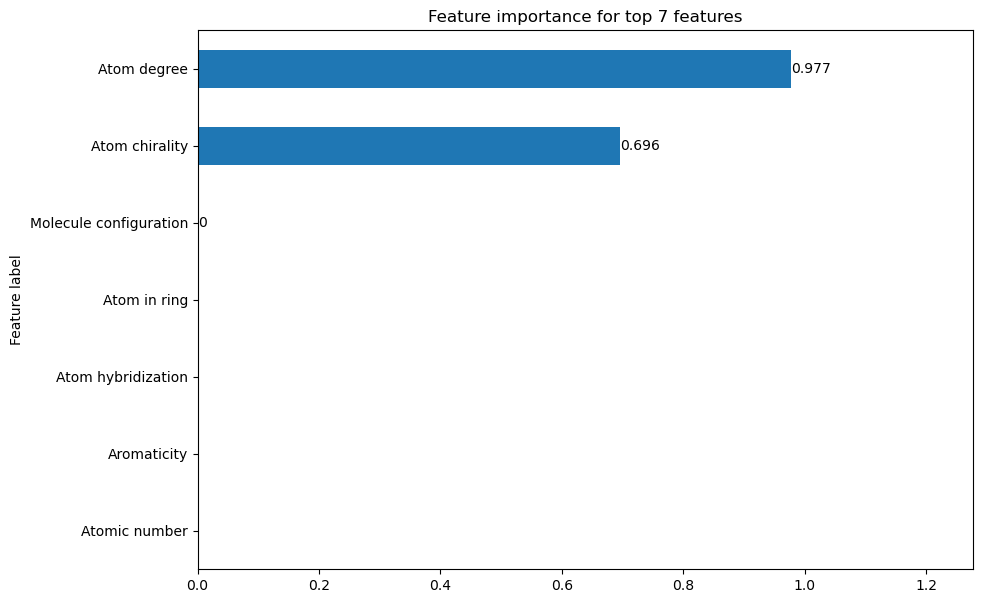

In [23]:
explanation.visualize_feature_importance(path=None, top_k=7, feat_labels = feat_labels)

In [25]:
main(mol_graph=mol, mol='l', explanation=explanation, palette='cb')

In [29]:
edge_idx = mol.edge_index

In [30]:
fa, la, coords, atom_symbol = mol_prep(mol_graph=mol, mol='l')

In [31]:
edge_coords = dict(zip(range(fa, la), coords))

In [32]:
edge_mask_dict, node_mask = get_masks(explanation=explanation, fa=fa, la=la, edge_idx=edge_idx)

In [33]:
'''mol_l = AddHs(Chem.MolFromSmiles(mol.ligand[0]))
mol_s = AddHs(Chem.MolFromSmiles(mol.substrate[0]))
mol_b = AddHs(Chem.MolFromSmiles(mol.boron[0]))'''

'mol_l = AddHs(Chem.MolFromSmiles(mol.ligand[0]))\nmol_s = AddHs(Chem.MolFromSmiles(mol.substrate[0]))\nmol_b = AddHs(Chem.MolFromSmiles(mol.boron[0]))'

In [34]:
'''atoms_l = mol_l.GetNumAtoms()
atoms_s = mol_s.GetNumAtoms()
atoms_b = mol_b.GetNumAtoms()'''

'atoms_l = mol_l.GetNumAtoms()\natoms_s = mol_s.GetNumAtoms()\natoms_b = mol_b.GetNumAtoms()'

In [35]:
'''def cuts(mol = 's'):
    if mol == 'l':
        fa = 0
        la = atoms_l-1
    elif mol == 's':
        fa = atoms_l
        la = atoms_l + atoms_s -1
    else:
        fa = atoms_l + atoms_s 
        la = atoms_l + atoms_s +atoms_b-1
    return fa, la

def mol_coords(mol):
    if mol == 'l':
        AllChem.EmbedMolecule(mol_l, AllChem.ETKDGv3())
        coords = mol_l.GetConformer().GetPositions()
    elif mol == 's':
        AllChem.EmbedMolecule(mol_s, AllChem.ETKDGv3())
        coords = mol_s.GetConformer().GetPositions()
    else:
        AllChem.EmbedMolecule(mol_b, AllChem.ETKDGv3())
        coords = mol_b.GetConformer().GetPositions()
    return coords

def get_Atoms(mol):
    if mol == 'l':
        atom_symbol = [atom.GetSymbol() for atom in mol_l.GetAtoms()]
    elif mol == 's':
        atom_symbol = [atom.GetSymbol() for atom in mol_s.GetAtoms()]
    else:
        atom_symbol = [atom.GetSymbol() for atom in mol_b.GetAtoms()]
    return atom_symbol'''


"def cuts(mol = 's'):\n    if mol == 'l':\n        fa = 0\n        la = atoms_l-1\n    elif mol == 's':\n        fa = atoms_l\n        la = atoms_l + atoms_s -1\n    else:\n        fa = atoms_l + atoms_s \n        la = atoms_l + atoms_s +atoms_b-1\n    return fa, la\n\ndef mol_coords(mol):\n    if mol == 'l':\n        AllChem.EmbedMolecule(mol_l, AllChem.ETKDGv3())\n        coords = mol_l.GetConformer().GetPositions()\n    elif mol == 's':\n        AllChem.EmbedMolecule(mol_s, AllChem.ETKDGv3())\n        coords = mol_s.GetConformer().GetPositions()\n    else:\n        AllChem.EmbedMolecule(mol_b, AllChem.ETKDGv3())\n        coords = mol_b.GetConformer().GetPositions()\n    return coords\n\ndef get_Atoms(mol):\n    if mol == 'l':\n        atom_symbol = [atom.GetSymbol() for atom in mol_l.GetAtoms()]\n    elif mol == 's':\n        atom_symbol = [atom.GetSymbol() for atom in mol_s.GetAtoms()]\n    else:\n        atom_symbol = [atom.GetSymbol() for atom in mol_b.GetAtoms()]\n    return ato

In [36]:
'''type = 'l'
fa, la = cuts(type)
coords = mol_coords(type)
atom_symbol = get_Atoms(type)'''

"type = 'l'\nfa, la = cuts(type)\ncoords = mol_coords(type)\natom_symbol = get_Atoms(type)"

In [37]:
'''edge_mask_dict = defaultdict(float)

for val, u, v in list(zip(edge_mask, *edge_idx)):
        u, v = u.item(), v.item()
        if u in range(fa, la):
                if u > v:
                        u, v = v, u
                edge_mask_dict[(u, v)] += val.item()'''

'edge_mask_dict = defaultdict(float)\n\nfor val, u, v in list(zip(edge_mask, *edge_idx)):\n        u, v = u.item(), v.item()\n        if u in range(fa, la):\n                if u > v:\n                        u, v = v, u\n                edge_mask_dict[(u, v)] += val.item()'

In [38]:
edge_mask_dict, node_mask = normalise_masks(edge_mask_dict=edge_mask_dict, node_mask=node_mask)

In [39]:
'''neg = [True if num < 0 else False for num in list(edge_mask_dict.values())]
min_value = abs(min(edge_mask_dict.values(), key=abs))
max_value = abs(max(edge_mask_dict.values(), key=abs))'''

'neg = [True if num < 0 else False for num in list(edge_mask_dict.values())]\nmin_value = abs(min(edge_mask_dict.values(), key=abs))\nmax_value = abs(max(edge_mask_dict.values(), key=abs))'

In [40]:
'''abs_dict = {key: abs(value) for key, value in edge_mask_dict.items()}
abs_dict = {key: (value - min_value) / (max_value - min_value) for key, value in abs_dict.items()}'''

'abs_dict = {key: abs(value) for key, value in edge_mask_dict.items()}\nabs_dict = {key: (value - min_value) / (max_value - min_value) for key, value in abs_dict.items()}'

In [41]:
'''edge_mask_dict = {key: -value if convert else value for (key, value), convert in zip(abs_dict.items(), neg)}'''

'edge_mask_dict = {key: -value if convert else value for (key, value), convert in zip(abs_dict.items(), neg)}'

In [42]:
'''node_mask = node_mask.sum(axis = 1)
node_mask = [val.item() for val in node_mask]'''

'node_mask = node_mask.sum(axis = 1)\nnode_mask = [val.item() for val in node_mask]'

In [43]:
'''neg_nodes = [True if num < 0 else False for num in node_mask]
max_node = abs(max(node_mask, key = abs))
min_node = abs(min(node_mask, key = abs))'''

'neg_nodes = [True if num < 0 else False for num in node_mask]\nmax_node = abs(max(node_mask, key = abs))\nmin_node = abs(min(node_mask, key = abs))'

In [44]:
'''abs_node = [abs(w) for w in node_mask]
abs_node = [(w-min_node)/(max_node-min_node) for w in abs_node]'''

'abs_node = [abs(w) for w in node_mask]\nabs_node = [(w-min_node)/(max_node-min_node) for w in abs_node]'

In [45]:
'''node_mask = [-w if neg_nodes else w for w, neg_nodes in zip(abs_node, neg_nodes)]'''

'node_mask = [-w if neg_nodes else w for w, neg_nodes in zip(abs_node, neg_nodes)]'

In [46]:
'''colors_n = {
    'C': 'black',
    'O': 'red',
    'N': 'blue',
    'H': 'lightgray',
    'B': 'brown'
}

colors_cb = {
    'C': '#333333',
    'O': '#FF0000',
    'N': '#0000FF',
    'H': '#FFFFFF',
    'B': '#FFA500'
}

sizes = {
    'C': 69/8,
    'O': 66/8,
    'N': 71/8,
    'H': 31/8,
    'B': 84/8
}'''

"colors_n = {\n    'C': 'black',\n    'O': 'red',\n    'N': 'blue',\n    'H': 'lightgray',\n    'B': 'brown'\n}\n\ncolors_cb = {\n    'C': '#333333',\n    'O': '#FF0000',\n    'N': '#0000FF',\n    'H': '#FFFFFF',\n    'B': '#FFA500'\n}\n\nsizes = {\n    'C': 69/8,\n    'O': 66/8,\n    'N': 71/8,\n    'H': 31/8,\n    'B': 84/8\n}"

In [47]:
'''colors = colors_cb'''

'colors = colors_cb'

In [48]:
coords_edges = [(np.concatenate([np.expand_dims(edge_coords[u], axis=1), np.expand_dims(edge_coords[v], axis =1)], 
                                axis = 1)) for u, v in edge_mask_dict.keys()]

In [49]:
edge_weights = list(edge_mask_dict.values())

In [50]:
rescaled_edges = [(x + 1) / 2 for x in edge_weights]
rescaled_nodes = [(x + 1) / 2 for x in node_mask]

In [51]:
neg_edges = [True if num < 0 else False for num in list(edge_mask_dict.values())]
neg_nodes = [True if num < 0 else False for num in node_mask]

In [52]:
colors, color_nodes, color_edges = select_palette(palette='cb', neg_nodes=neg_nodes, neg_edges=neg_edges)

In [53]:
nt = 8
sizes = {
    'C': 69/nt,
    'O': 66/nt,
    'N': 71/nt,
    'H': 31/nt,
    'B': 84/nt
}

In [66]:
trace_atoms = [None] * len(atom_symbol)
trace_atoms_imp = [None] * len(atom_symbol)
trace_edges = [None] * len(edge_mask_dict)
trace_edge_imp = [None] * len(edge_mask_dict)

for i in range(len(atom_symbol)):

    trace_atoms[i] = go.Scatter3d(x=[coords[i][0]],
                         y=[coords[i][1]],
                         z=[coords[i][2]],
                         mode='markers',
                         legendgroup='Atoms',
                         showlegend=False,
                         text = f'atom {atom_symbol[i]}',
                         marker=dict(symbol='circle',
                                                 size=sizes[atom_symbol[i]],
                                                 color=colors[atom_symbol[i]])
    )



for i in range(len(atom_symbol)):

    trace_atoms_imp[i] = go.Scatter3d(x=[coords[i][0]],
                         y=[coords[i][1]],
                         z=[coords[i][2]],
                         mode='markers',
                         showlegend=False,
                         opacity=rescaled_nodes[i],
                         hovertemplate='Label: %{text}<extra></extra>',
                         text = f'atom {atom_symbol[i]}',
                         legendgroup='Atom importance',
                         marker=dict(symbol='circle',
                                                 size=sizes[atom_symbol[i]]*1.7,
                                                 color=color_nodes[i])
    )

for i in range(len(edge_mask_dict)):
    
    trace_edges[i]= go.Scatter3d(
        x=coords_edges[i][0],
        y=coords_edges[i][1],
        z=coords_edges[i][2],
        mode='lines',
        showlegend=False,
        legendgroup='Bonds',
        line=dict(color='black', width=2),
        hoverinfo='none')


for i in range(len(edge_mask_dict)):
    
    trace_edge_imp[i]= go.Scatter3d(
        x=coords_edges[i][0],
        y=coords_edges[i][1],
        z=coords_edges[i][2],
        mode='lines',
        showlegend=False,
        legendgroup='Bond importance',
        opacity=rescaled_edges[i],
        line=dict(color=color_edges[i], width=rescaled_edges[i]*15),
        hoverinfo='none')
    


traces =   trace_atoms + trace_edges + trace_edge_imp + trace_atoms_imp
fig = go.Figure(data=traces)

fig.add_trace(go.Scatter3d(
    x=[None],
    y=[None],
    z=[None],
    mode='markers',
    legendgroup='Atoms',
    name='Atoms'
))

fig.add_trace(go.Scatter3d(
    x=[None],
    y=[None],
    z=[None],
    mode='markers',
    legendgroup='Atom importance',
    name='Atom importance'
))

fig.add_trace(go.Scatter3d(
    x=[None],
    y=[None],
    z=[None],
    mode='markers',
    legendgroup='Bonds',
    name='Bonds'
))

fig.add_trace(go.Scatter3d(
    x=[None],
    y=[None],
    z=[None],
    mode='markers',
    legendgroup='Bond importance',
    name='Bond importance',
    showlegend=True
))

fig.update_layout(template =  'plotly_white')

fig.update_layout(scene=dict(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             zaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             xaxis_title='', yaxis_title='', zaxis_title=''))


fig.show()

In [62]:
import plotly.graph_objects as go

# Create data points
x = [1, 2, 3]
y = [4, 5, 6]
labels = ['A', 'B', 'C']

# Create a scatter trace with custom hover template
trace = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    hovertemplate='Label: %{text}<extra></extra>',
    text=labels
)

# Create the data list with the scatter trace
data = [trace]

# Create the layout
layout = go.Layout()

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()

In [44]:
from torch_geometric.explain.metric import fidelity, fidelity_curve_auc, characterization_score, groundtruth_metrics

In [45]:
fid_pm = fidelity(explainer, explanation)
fid_pm

(0.0, 1.0)

In [46]:
characterization_score(torch.tensor(fid_pm[1]), torch.tensor(fid_pm[0]))

tensor(1.)

In [22]:
import networkx as nx
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

In [23]:
def to_molecule(data):
    ATOM_MAP = {1:'H', 5: 'B', 6:'C', 7:'N', 8:'O', 9:'F', 15:'P', 16:'S', 
                17:'Cl', 33:'As', 34:'Se', 35:'Br', 53:'I'}
    
    ligand = Chem.AddHs(Chem.MolFromSmiles(data.ligand))
    ligand_atoms = ligand.GetNumAtoms()
    AllChem.EmbedMolecule(ligand, AllChem.ETKDGv3())
    
    substrate = Chem.AddHs(Chem.MolFromSmiles(data.substrate))
    substrate_atoms = substrate.GetNumAtoms()
    AllChem.EmbedMolecule(substrate, AllChem.ETKDGv3())

    boron = rdmolops.AddHs(Chem.MolFromSmiles(data.boron))
    boron_atoms = boron.GetNumAtoms()
    AllChem.EmbedMolecule(boron, AllChem.ETKDGv3())

    ligand_coords = ligand.GetConformer().GetPositions()

    substrate_coords = substrate.GetConformer().GetPositions()
    #substrate_coords[:,0] = substrate_coords[:,0]+1+max(ligand_coords[:,0])

    boron_coords = boron.GetConformer().GetPositions()
    #boron_coords[:,0] = boron_coords[:,0]+1+max(substrate_coords[:,0])

    coords = np.concatenate([ligand_coords, substrate_coords, boron_coords], axis = 0)
    
    g = to_networkx(data, node_attrs=['x'])

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'][0]]
        if u < ligand_atoms:
            data['mol'] = 'l'
        elif ligand_atoms <= u < substrate_atoms+ligand_atoms:
            data['mol'] = 's'
        else:
            data['mol'] = 'b'
        del data['x']
    return g, coords

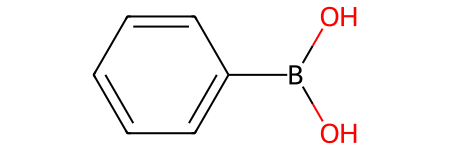

In [24]:
structure = ligands[test_idx[4]][26]
G, pos = to_molecule(structure)
Chem.MolFromSmiles(structure.boron)

In [25]:
ligand = nx.Graph()
substrate = nx.Graph()
boron = nx.Graph()

In [26]:
for u, feat in G.nodes(data = True):
    if feat['mol'] == 'l':
        ligand.add_node(u, name = feat['name'], coords = pos[u], an = u)
    elif feat['mol'] == 's':
        substrate.add_node(u, name = feat['name'], coords = pos[u], an = u)
    else:
        boron.add_node(u, name = feat['name'], coords = pos[u], an = u)

nodes_ligand = set(ligand.nodes())
nodes_substrate = set(substrate.nodes())
nodes_boron = set(boron.nodes())

In [27]:
ligand.add_edges_from(G.edges())
substrate.add_edges_from(G.edges())
boron.add_edges_from(G.edges())

In [28]:
# Delete edges not connecting nodes in the node set
for u, v in list(G.edges()):

    if u not in nodes_ligand or v not in nodes_ligand:
        try:
            ligand.remove_edge(u, v)
        except:
            pass

    if u not in nodes_substrate or v not in nodes_substrate:
        try:
            substrate.remove_edge(u, v)
        except:
            pass

    if u not in nodes_boron or v not in nodes_boron:
        try:
            boron.remove_edge(u, v)
        except:
            pass

for u in list(G.nodes()):
    if u not in nodes_ligand:
        ligand.remove_node(u)
    if u not in nodes_substrate:
        substrate.remove_node(u)
    if u not in nodes_boron:
        boron.remove_node(u)

In [29]:
ligand_xyz = np.array([pos[v] for v in sorted(ligand)])
edge_ligand = np.array([(pos[u], pos[v]) for u, v in ligand.edges()])
edges_l = [(u, v) for u, v in ligand.edges()]
ligand_an = [ligand.nodes[node]['an'] for node in ligand.nodes()]

substrate_xyz = np.array([pos[v] for v in sorted(substrate)])
edge_subs = np.array([(pos[u], pos[v]) for u, v in substrate.edges()])
edges_s = [(u, v) for u, v in substrate.edges()]
subs_an = [substrate.nodes[node]['an'] for node in substrate.nodes()]

boron_xyz = np.array([pos[v] for v in sorted(boron)])
edge_boron = np.array([(pos[u], pos[v]) for u, v in boron.edges()])
edges_b = [(u, v) for u, v in boron.edges()]
boron_an = [boron.nodes[node]['an'] for node in boron.nodes()]


edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

In [30]:
colors = {
    'C': 'black',
    'O': 'red',
    'N': 'blue',
    'H': 'lightgray',
    'B': 'brown'
}

sizes = {
    'C': 69/8,
    'O': 66/8,
    'N': 71/8,
    'H': 31/8,
    'B': 84/8
}

In [45]:
trace_atoms = [None] * len(boron.nodes)
trace_edges = [None] * len(edge_boron)

for i, u in zip(range(len(boron.nodes)), boron.nodes):


    trace_atoms[i] = go.Scatter3d(x=[boron_xyz[i][0]],
                         y=[boron_xyz[i][1]],
                         z=[boron_xyz[i][2]],
                         mode='markers',
                         name = f'atom {boron_an[i]}',
                         text = f'atom {boron_an[i]}',
                         marker=dict(symbol='circle',
                                                 size=sizes[boron.nodes[u]['name']],
                                                 color=colors[boron.nodes[u]['name']])
    )

for i in range(len(edge_boron)):
    trace_edges[i]= go.Scatter3d(
        x=edge_boron[i,:,0],
        y=edge_boron[i,:,1],
        z=edge_boron[i,:,2],
        name = f'Atom {edges_b[i][0]} - Atom {edges_b[i][1]}',
        text=f'{edges_b[i]}',
        mode='lines',
        line=dict(color='black', width=2),
        hoverinfo='none')


traces =  trace_edges + trace_atoms
subs = go.Figure(data=traces)

subs.update_layout(template =  'plotly_white')

subs.update_layout(scene=dict(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             zaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             xaxis_title='', yaxis_title='', zaxis_title=''))


subs.show()

In [32]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [33]:
from collections import defaultdict

In [34]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        edge_mask_dict[(u, v)] += val

    return edge_mask_dict

In [35]:
edge_mask = explain('ig', structure, target=0)
edge_mask_dict = aggregate_edge_directions(edge_mask, structure)

In [36]:
for u, v in edge_mask_dict:
    edge_mask_dict[(u, v)] += edge_mask_dict[(v, u)] 
    edge_mask_dict[(v, u)] = edge_mask_dict[(u, v)]

In [37]:
mask_ligand = {key: edge_mask_dict[key] for key in edges_l}

In [38]:
weights = list(mask_ligand.values())
weights = (weights - min(weights))/(max(weights)- min(weights))
edges = list(mask_ligand.keys())

In [43]:
trace_atoms = [None] * len(ligand.nodes)
trace_edges = [None] * len(edge_ligand)
trace_imp = [None] * len(weights)

for i, u in zip(range(len(edge_xyz)), ligand.nodes):


    trace_atoms[i] = go.Scatter3d(x=[ligand_xyz[u][0]],
                         y=[ligand_xyz[u][1]],
                         z=[ligand_xyz[u][2]],
                         mode='markers',
                         name = f'atom {ligand_an[i]}',
                         text = f'atom {ligand_an[i]}',
                         marker=dict(symbol='circle',
                                                 size=sizes[ligand.nodes[u]['name']],
                                                 color=colors[ligand.nodes[u]['name']])
    )

for i in range(len(edge_ligand)):
    trace_edges[i]= go.Scatter3d(
        x=edge_ligand[i,:,0],
        y=edge_ligand[i,:,1],
        z=edge_ligand[i,:,2],
        name = f'Atom {edges_l[i][0]} - Atom {edges_l[i][1]}',
        text=f'{edges_l[i]}',
        mode='lines',
        line=dict(color='black', width=2),
        hoverinfo='none')
    


for i in range(len(edge_ligand)):
    trace_imp[i]= go.Scatter3d(
        x=edge_ligand[i,:,0],
        y=edge_ligand[i,:,1],
        z=edge_ligand[i,:,2],
        name= f'atom{edges[i][0]}-atom{edges[i][1]}',
        mode='lines',
        opacity=weights[i],
        line=dict(color='red', width=weights[i]*10),
        hoverinfo='none')


traces =   trace_edges + trace_imp + trace_atoms
subs = go.Figure(data=traces)
subs.update_layout(template =  'plotly_white')

subs.update_layout(scene=dict(xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             zaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                             xaxis_title='', yaxis_title='', zaxis_title=''))

subs.show()

In [38]:
import networkx as nx
from torch_geometric.utils import to_networkx


def draw_molecule(g, edge_mask=None, mol='l', draw_edge_labels=False):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in list(g.nodes(data=True)):
        if data['mol'] == mol:
            node_labels[u] = data['name']
        else:
            g.remove_node(u)
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]

    nx.draw(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Reds,
            node_color='azure')
    
    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}    
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red')
    plt.show()


def to_molecule(data):
    ATOM_MAP = {1:'H', 5: 'B', 6:'C', 7:'N', 8:'O', 9:'F', 15:'P', 16:'S', 
                17:'Cl', 33:'As', 34:'Se', 35:'Br', 53:'I'}
    
    ligand_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.ligand)).GetNumAtoms()
    substrate_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.substrate)).GetNumAtoms()
    boron_atoms = rdmolops.AddHs(Chem.MolFromSmiles(data.boron)).GetNumAtoms()
    
    g = to_networkx(data, node_attrs=['x'])

    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'][0]]
        if u < ligand_atoms:
            data['mol'] = 'l'
        elif ligand_atoms <= u < substrate_atoms+ligand_atoms:
            data['mol'] = 's'
        else:
            data['mol'] = 'b'
        del data['x']
    return g

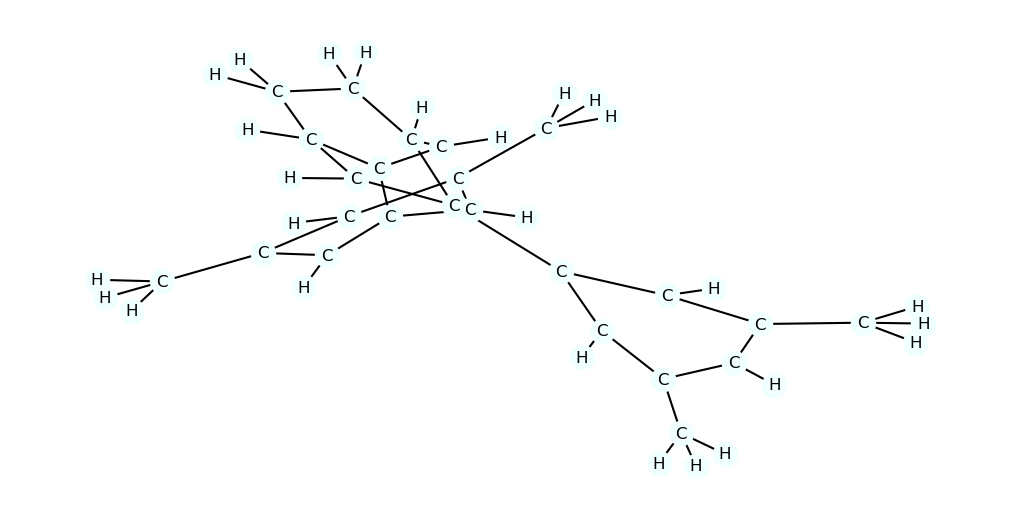

In [39]:
data = ligands[test_idx[4]][26]
mol = to_molecule(data)
plt.figure(figsize=(10, 5))
draw_molecule(mol, mol='l')

In [40]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device)
    out = model(data.x, data.edge_index, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask

In [41]:
from collections import defaultdict

In [42]:
def aggregate_edge_directions(edge_mask, data):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *data.edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict

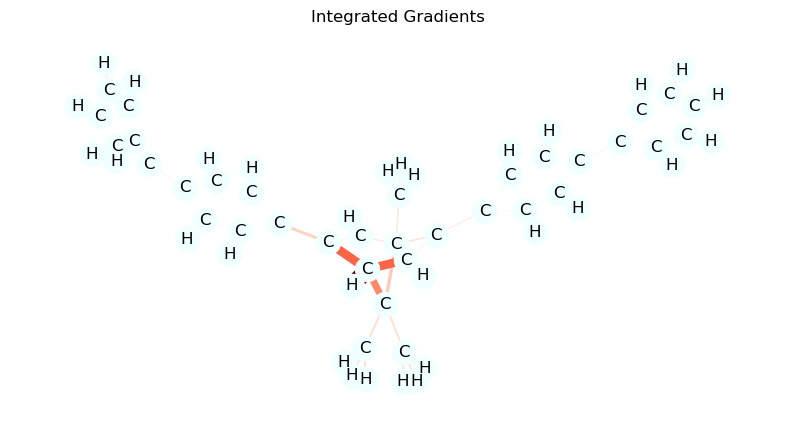

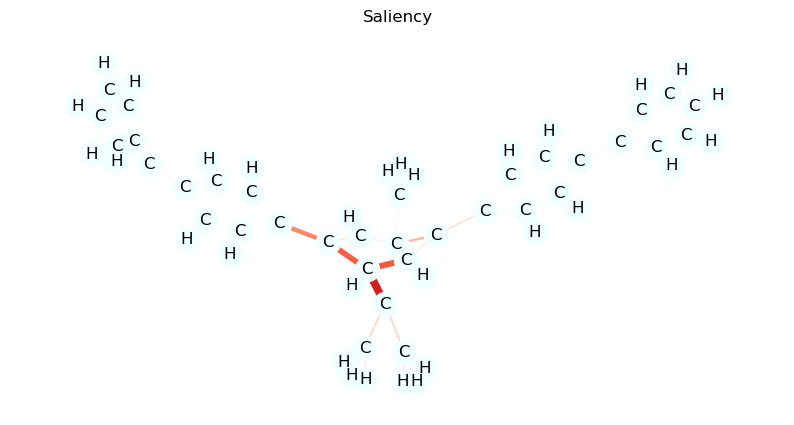

In [43]:
data = ligands[test_idx[0]][9]

mol = to_molecule(data)

for title, method in [('Integrated Gradients', 'ig'), ('Saliency', 'saliency')]:
    edge_mask = explain(method, data, target=0)
    edge_mask_dict = aggregate_edge_directions(edge_mask, data)
    plt.figure(figsize=(10, 5))
    plt.title(title)
    draw_molecule(mol, edge_mask_dict, mol = 'l')